# Measuring Access to Healthcare in the IE

### Software

To do a full-statck assessment of accessibility we need to link together a few diferent pieces of software:

- [`urbanaccess`]() builds a routable, multimodal transportation network. It consumes data from (1) OpenStreetMap and (2) GTFS and combines them into a network whose distance between nodes is measured in travel time
- [`pandana`]() finds the shortest path through the network between all pairs of nodes using fast underlying C++ library, and can optionally create distance-weighted sums of resources--a simple measurre of accessibility that accounts for space but not competition. `pandana` consumes (1) the network generated by `urbanaccess` and (2) a set of oigins and (3) destinations. We will use `pandana` to create the shortest-path travel cost matrix relating origins to destinations
- [`access`]() creates measures of accessibility that account for distance traveled and include various weighting schemes to discount for competition. `accesss` consumes geodataframes representing (1) supply and (2) demand, and (3) a travel cost matrix. In our case, (1) is equivalent to the desitnation set above, (2) is a set of population counts, and (3) is the output from `pandana`

In short: 
1. we use `urbanaccess` to collect and process our network data.
2. we use `pandana` to calculate the travel cost matrix for
3. we feed the travel cost matrix to `access` to generate a variety of accessibility measures

## Data

- OSM
    - urbanaccess (and osmnet) have the ability to download data from OSM in the format they need using a function called `network_from_bbox` which is nice, but can be very time consuming depending on the size of the network
    - I have stored pre-built metropolitan scale networks (extending 8km beyond the metro border, so supporting queries up to that range) in [our quilt bucket](https://open.quiltdata.com/b/spatial-ucr/packages/osm/metro_networks_8k)
- GTFS
    - [transitfeeds](https://transitfeeds.com/p/riverside-transit-agency/531) is a good place to get up-to-date gtfs data, but it can be hard to ensure you've included every relevant transit agency serving the study area (and impossible to know whether there's another agency that hasnt yet posted its data there)

In [48]:
import quilt3
import pandas as pd
import numpy as np
import geopandas as gpd
import urbanaccess as ua
from access import access
import pandana as pdna
import os
from tqdm.auto import tqdm

### Creating a multimodal network

download OSM data from our quilt bucket

In [2]:
if not os.path.exists("../data/40140.h5"):
    p = quilt3.Package.browse("osm/metro_networks_8k", "s3://spatial-ucr")
    p['40140.h5'].fetch(dest="../data/")

In [3]:
# read in the pre-saved OSM network using pandana

osm_network = pdna.Network.from_hdf5("../data/40140.h5")

Now we read in GTFS data using urbanaccess. From here, we're essentially following the tutorial from https://github.com/UDST/urbanaccess/blob/dev/demo/simple_example.ipynb

Two things to note:
- First, `ua` uses a deprecated pandas convention (`to_matrix` instead of `values`) so you need to either fix that code in `network.py` or install the version from my fork. 
- Second `ua` makes some  nontraditional design desisions. Rather than expose something like a Network class, they keep track of a global network object in  `ua.network.ua_network`. Thus, most of the functions dont return  an object, but modify the global network 

In [4]:
bbox=(-117.802539  ,   33.425932  , -114.131211  ,   35.80962942)

We can use the built-in downloader to grab GTFS data for riverside county

In [5]:
ua.gtfsfeeds.search(search_text='riverside', add_feed=True)
ua.gtfsfeeds.search(search_text='omnitrans', add_feed=True)

ua.gtfsfeeds.download(data_folder="../data")

Note: Your use of a GTFS feed is governed by each GTFS feed author license terms. It is suggested you read the respective license terms for the appropriate use of a GTFS feed.
Found 2 records that matched ['riverside'] inside ['name', 'url', 'dataexchange_id', 'feed_baseurl'] columns:
Added 2 feeds to gtfs_feeds: {'Riverside Transit Agency': 'http://www.gtfs-data-exchange.com/agency/riverside-transit-agency/latest.zip', 'Palo Verde Valley Transit Agency': 'http://www.gtfs-data-exchange.com/agency/palo-verde-valley-transit-agency/latest.zip'}
Added 2 records to gtfs_feed list:
Note: Your use of a GTFS feed is governed by each GTFS feed author license terms. It is suggested you read the respective license terms for the appropriate use of a GTFS feed.
Found 1 records that matched ['omnitrans'] inside ['name', 'url', 'dataexchange_id', 'feed_baseurl'] columns:
Added 1 feeds to gtfs_feeds: {'OMNITRANS': 'http://www.gtfs-data-exchange.com/agency/omnitrans/latest.zip'}
Added 1 records to gtfs

In [6]:
loaded_feeds = ua.gtfs.load.gtfsfeed_to_df("../data/gtfsfeed_text/", bbox=bbox)

GTFS text file header whitespace check completed. Took 0.32 seconds
--------------------------------
Processing GTFS feed: ivt_gtfs_data
The unique agency id: imperial_valley_transit was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.01 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Appended route type to stops
Appended route type to stop_times
--------------------------------
--------------------------------
Processing GTFS feed: Palo Verde Valley Transit Agency
The unique agency id: palo_verde_valley_transit_agency was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.01 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Appended route type to stops
Appended route type to stop_times
--------------------------------
--------------------------------
Processing GTFS feed: OMNITRANS
The unique agency id: omnitrans was generated using the n

In [7]:
# transform the raw gtfs data into a transit network

ua.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
14 service_ids were extracted from calendar
7,875 trip(s) 45.50 percent of 17,307 total trip records were found in calendar for GTFS feed(s): ['ivt gtfs data', 'palo verde valley transit agency', 'omnitrans', 'riverside transit agency', 'san nern', 'google transit']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
7,875 of 17,307 total trips were extracted representing calendar day: monday. Took 0.03 seconds
Note: Processing may take a long time depending on the number of records. Total unique trips to assess: 6,777
Starting departure stop time interpo

Now we create `ua` version of the OSM version we read in earlier using pandana.  Pandana and urbanaccess share a lot of underlying code but their objects arent interchangeable. So there's probably a way to just read in the OSM data using `ua` instead of `pandana`, but this is the path of least resistance

In [9]:
osm_network.nodes_df['id'] = osm_network.nodes_df.index

In [10]:
ua_osm = ua.create_osm_net(osm_edges=osm_network.edges_df,
                              osm_nodes=osm_network.nodes_df,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.01 seconds


Here, we create a pointer to the global network so that it's easier to inspect

In [8]:
urbanaccess_net = ua.ua_network

Now all we have to do is integrate the networks

In [11]:
ua.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False
                             )

Loaded UrbanAccess network components comprised of:
     Transit: 9,921 nodes and 83,225 edges;
     OSM: 486,514 nodes and 742,113 edges
Connector edges between the OSM and transit network nodes successfully completed. Took 4.45 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 4.17 seconds
Network edge and node network integration completed successfully resulting in a total of 496,435 nodes and 1,388,730 edges:
     Transit: 9,921 nodes 83,225 edges;
     OSM: 486,514 nodes 742,113 edges; and
     OSM/Transit connector: 19,842 edges.


we'll save the network so that we dont need to do all that data processing if we want to analyze the IE in the future

In [13]:
# I think somewhere ua has hardcoded the paths to be `logs` inside the cwd, so you need to move up *two* levels
ua.save_network(urbanaccess_network=urbanaccess_net,
                        filename='../../data/ie_combined_net.h5',
                        overwrite_key = True)

Using existing data/../../data/combined_net.h5 hdf5 store.
Existing edges overwritten in data/../../data/combined_net.h5 hdf5 store.
Using existing data/../../data/combined_net.h5 hdf5 store.
Existing nodes overwritten in data/../../data/combined_net.h5 hdf5 store.


finally, we create a pandana Network object using the multimodal files we processed with urbanaccess

In [14]:
combined_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                            urbanaccess_net.net_nodes["y"],
                              urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]])

Figure created. Took 184.38 seconds


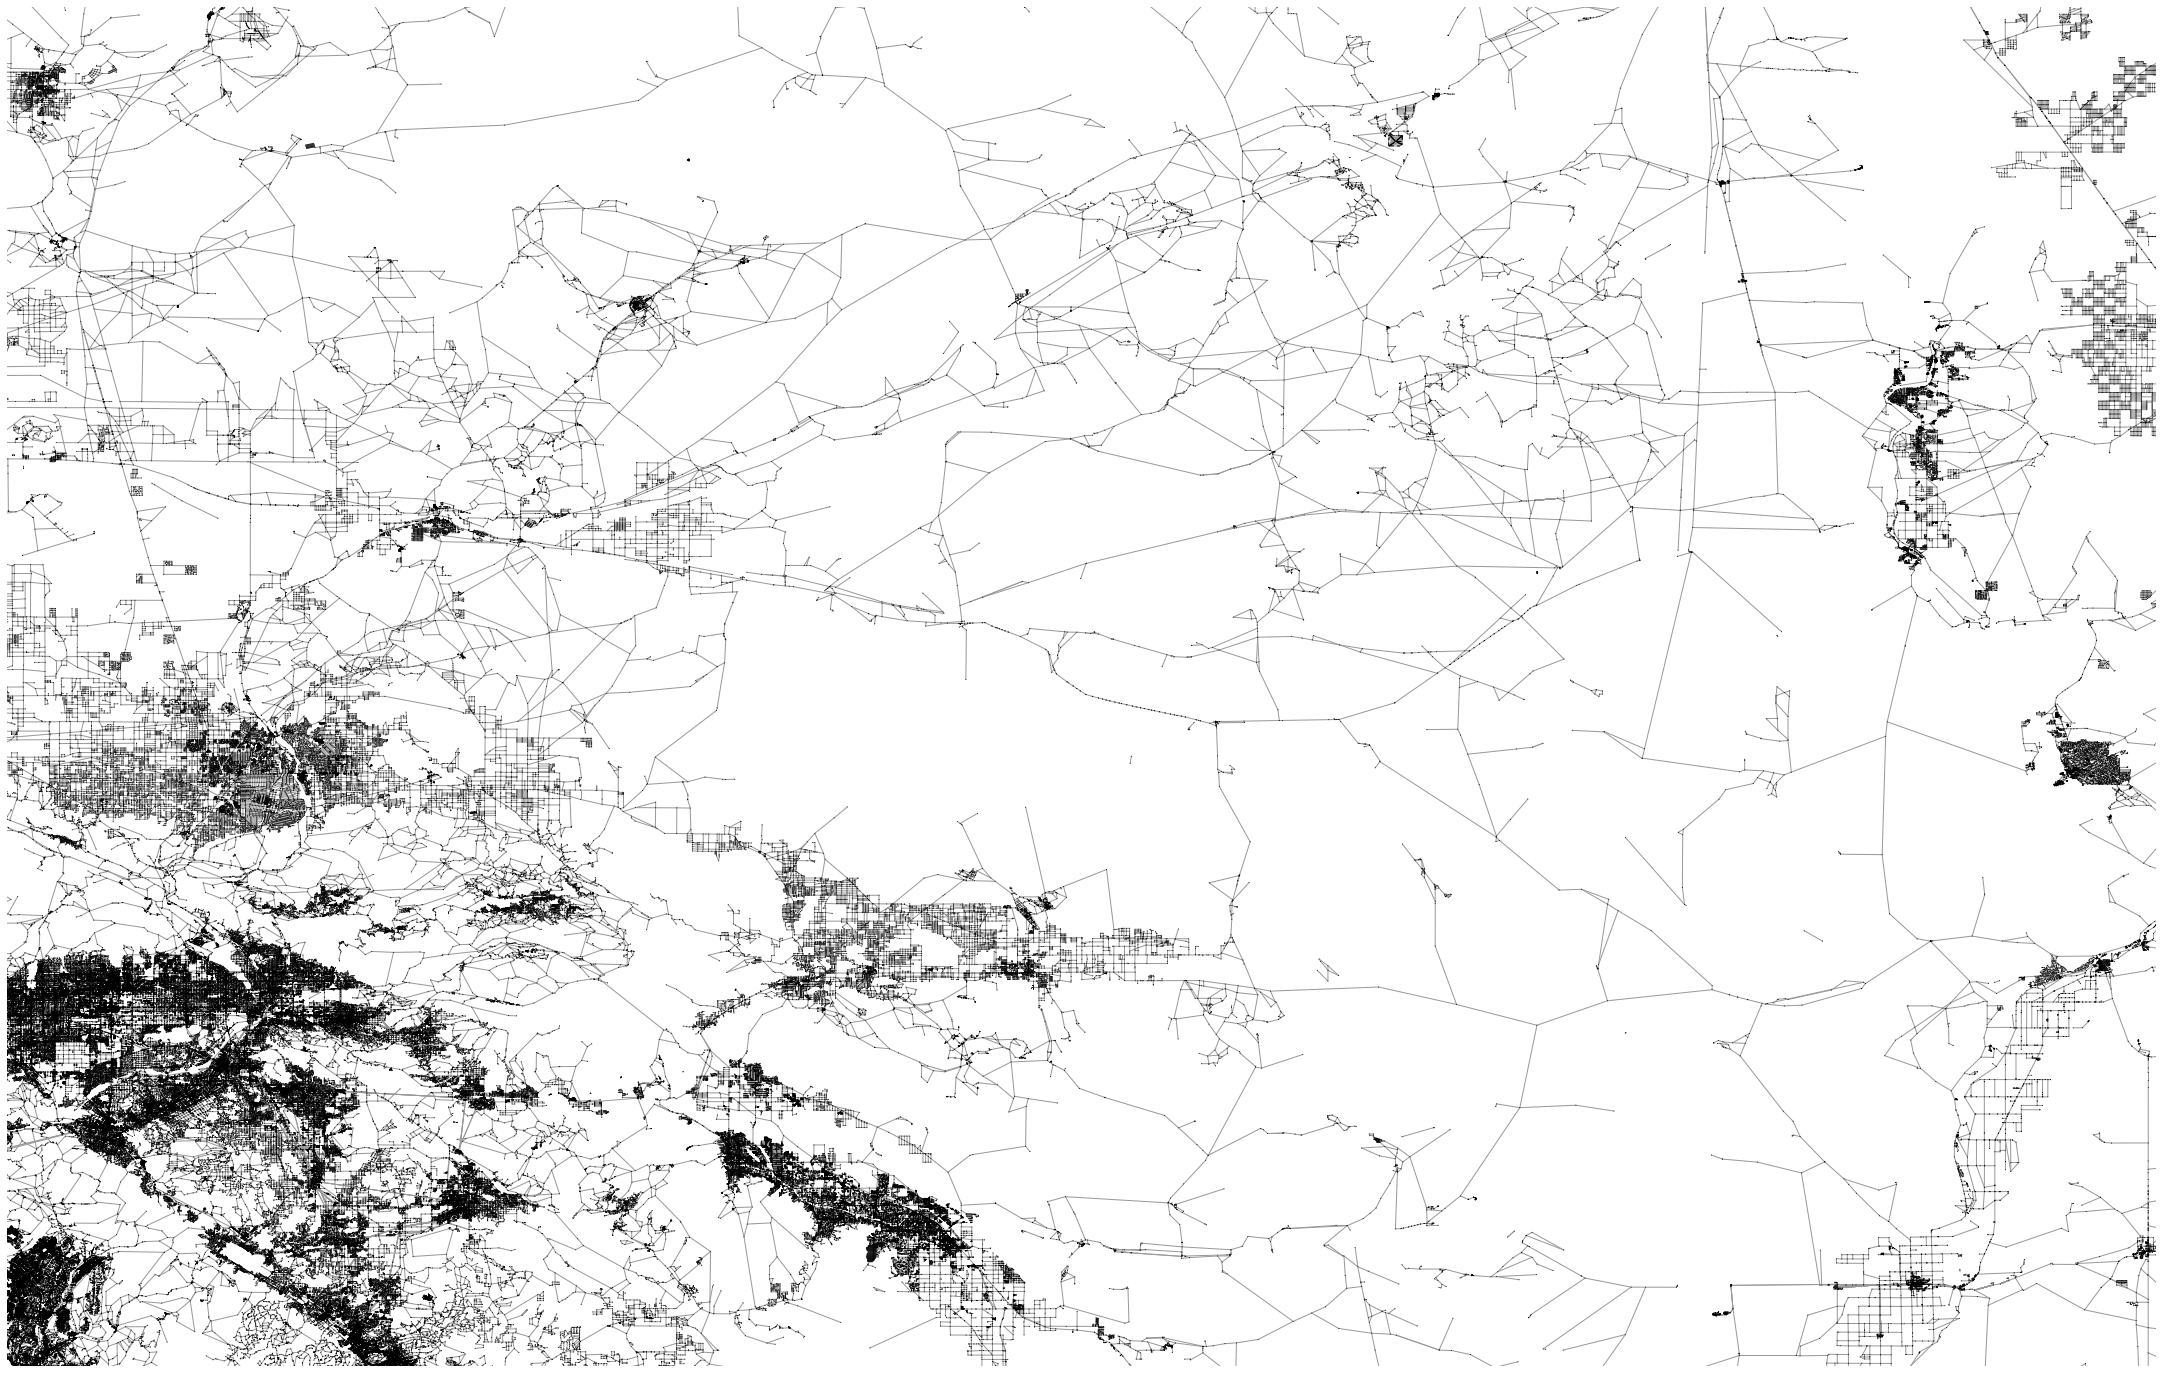

(<Figure size 2772.33x1800 with 1 Axes>, <AxesSubplot:>)

In [15]:
ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                          edges=urbanaccess_net.net_edges,
                          bbox=(-117.802539  ,   33.425932  , -114.131211  ,   35.80962942),
                          fig_height=25,
                          margin=0.02,
                          edge_linewidth=1,
                          edge_alpha=1,
                          node_color='black',
                          node_size=1,
                          node_alpha=1,
                          node_edgecolor='none',
                          node_zorder=3,
                          nodes_only=False)

## Generating Travel Time Matrices

first, we'll use geosnap to quickly grab population and geodata for the study region

In [16]:
from geosnap import Community

Loading manifest: 100%|██████████| 5/5 [00:00<00:00, 9545.53entries/s]


In [17]:
socal = Community.from_census(msa_fips='40140', years=[2010])

In [18]:
socal = socal.gdf

And we can use `osmnx` to quickly get poi data related to healthcare locations from openstreetmap

In [19]:
from osmnx import pois

In [20]:
health = pois.pois_from_polygon(socal.unary_union, tags={'amenity':['doctor', 'hospital'],
                                                         'healthcare': True})

<AxesSubplot:>

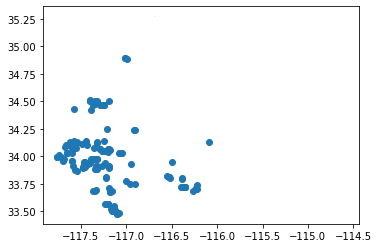

In [21]:
health.plot()

In [22]:
health['care'] = 1  # this is an indicator variable we'll use to tell `access` how much supply is at each location. Since we don't have the amount of staff at each location, we'll just count each individual unit

This function uses the shortest path functionality in pandana to calculate
the quickest walking path between every paid of tracts in the IE region

In [23]:
def compute_travel_cost_matrix(origins, destinations, network, reindex_name=False):
    origins = origins.copy()
    destinations = destinations.copy()
    
    origins['osm_ids'] = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
    destinations['osm_ids'] = network.get_node_ids(destinations.centroid.x, destinations.centroid.y).astype(int)
    
    ods = {}

    with tqdm(total=len(origins['osm_ids'])) as pbar:
        for origin in origins['osm_ids']:
            ods[f"{origin}"] = network.shortest_path_lengths([int(origin)] * len(origins), destinations['osm_ids'])
            pbar.update(1)
    
    if reindex_name:
        df = pd.DataFrame(ods, index=origins[reindex_name])
        df.columns = df.index
    else:
        df = pd.DataFrame(ods, index=origins)
    
    return df

And this function does the same thing, but formats the results as an adjacency list rather than a matrix

In [45]:
def compute_travel_cost_adjlist(origins, destinations, network, reindex_orig=None, reindex_dest=None):
    origins = origins.copy()
    destinations = destinations.copy()
    
    origins['osm_ids'] = network.get_node_ids(origins.centroid.x, origins.centroid.y).astype(int)
    destinations['osm_ids'] = network.get_node_ids(destinations.centroid.x, destinations.centroid.y).astype(int)
    
    ods = []
    
    # I dont think there's a way to do this in parallel, so we can at least show a progress bar
    with tqdm(total=len(origins['osm_ids'])) as pbar:
        for origin in origins['osm_ids']:
            df = pd.DataFrame()
            df['cost'] = network.shortest_path_lengths([int(origin)] * len(origins), destinations['osm_ids'])
            if reindex_dest:
                df['destination'] = destinations[reindex_dest].values
                df['origin'] = origins[origins.osm_ids==origin][reindex_orig].values[0]
            else:
                df['destination'] = destinations['osm_ids']
                df['origin'] = origin
            ods.append(df)
            pbar.update(1)
    
    combined = pd.concat(ods)
    
    return combined

In [25]:
# matrix style
tract_cost = compute_travel_cost_matrix(socal, socal, combined_net, reindex_name='geoid')

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [26]:
tract_cost

geoid        06071009112  06071009713  06071009800  06071009912  06071010016  \
geoid                                                                          
06071009112        0.000      302.859      151.045      132.090      191.626   
06071009713      302.859        0.000      157.411      195.046      304.785   
06071009800      151.045      157.411        0.000       49.118      164.134   
06071009912      132.090      195.046       49.118        0.000      123.372   
06071010016      191.626      304.785      164.134      123.372        0.000   
...                  ...          ...          ...          ...          ...   
06065042738      668.674      732.270      649.430      600.557      513.097   
06065043309      683.414      747.010      664.170      615.297      527.837   
06071006700      607.406      671.002      588.162      539.289      451.829   
06071008500      672.581      736.177      653.337      604.464      517.004   
06065044804     1284.445     1348.041     1265.201     1216.328     1128.868   

geoid        06071010420  06071011102  06071011600  06071012300  06065042005  \
geoid                                                                          
06071009112     1540.574      672.378      848.217      594.540      654.099   
06071009713     1267.512      544.420      898.079      658.136      717.695   
06071009800     1401.601      578.794      789.073      575.296      634.855   
06071009912     1414.806      552.946      834.687      526.423      585.982   
06071010016     1412.153      500.943      940.407      438.963      498.522   
...                  ...          ...          ...          ...          ...   
06065042738     1160.384      517.942     1433.224      109.691       79.935   
06065043309     1137.209      532.682     1447.964      124.431       94.675   
06071006700     1234.714      457.216     1371.956       48.960       89.130   
06071008500     1228.599      519.499     1437.131       96.522      141.577   
06065044804      714.121     1086.858     2048.995      725.462      695.706   

geoid        ...  06065031401  06065040806  06065042009  06065040603  \
geoid        ...                                                       
06071009112  ...      623.259      707.295      651.496      648.267   
06071009713  ...      686.855      770.891      715.092      711.863   
06071009800  ...      604.015      688.051      632.252      629.023   
06071009912  ...      555.142      639.178      583.379      580.150   
06071010016  ...      467.682      551.718      495.919      492.690   
...          ...          ...          ...          ...          ...   
06065042738  ...       73.407      156.768       60.292       98.415   
06065043309  ...       88.147      171.508       75.032      113.155   
06071006700  ...       58.290      142.326       86.527       83.298   
06071008500  ...      110.737      194.773      138.974      135.745   
06065044804  ...      689.178      772.539      676.063      714.186   

geoid        06065040701  06065042738  06065043309  06071006700  06071008500  \
geoid                                                                          
06071009112      674.304      668.674      683.414      607.406      672.581   
06071009713      737.900      732.270      747.010      671.002      736.177   
06071009800      655.060      649.430      664.170      588.162      653.337   
06071009912      606.187      600.557      615.297      539.289      604.464   
06071010016      518.727      513.097      527.837      451.829      517.004   
...                  ...          ...          ...          ...          ...   
06065042738      124.452        0.000       34.885      103.705      156.152   
06065043309      139.192       34.885        0.000      118.445      170.892   
06071006700      109.335      103.705      118.445        0.000      112.490   
06071008500      161.782      156.152      170.892      112.490        0.000   
06065044804      740.

In [49]:
# adjacency list style; this is what `access` needs
tract_adjlist = compute_travel_cost_adjlist(socal, socal, combined_net, reindex_dest='geoid', reindex_orig='geoid')

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [50]:
tract_adjlist

cost  destination       origin
0      0.000  06071009112  06071009112
1    302.859  06071009713  06071009112
2    151.045  06071009800  06071009112
3    132.090  06071009912  06071009112
4    191.626  06071010016  06071009112
..       ...          ...          ...
817  635.916  06065042738  06065044804
818  612.741  06065043309  06065044804
819  719.476  06071006700  06065044804
820  771.923  06071008500  06065044804
821    0.000  06065044804  06065044804

[675684 rows x 3 columns]

In [29]:
joined  = gpd.sjoin(socal, health[['geometry', 'care']], op='intersects', how='left').groupby('geoid').sum()['care']

/home/knaaptime/anaconda3/envs/healthacc/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [30]:
socal = socal.dropna(subset=['n_total_pop'])

In [31]:
socal = socal.merge(joined, left_on='geoid', right_index=True)

## Calculating Accessibility to Healthcare

In [32]:
ac = access(demand_df = socal,
            demand_index = 'geoid',
            demand_value = 'n_total_pop',
            supply_df    = socal,
            supply_index = 'geoid',
            cost_df=tract_adjlist,
            cost_origin='origin',
            cost_dest='destination',
            cost_name='cost',
            supply_value='care',
            neighbor_cost_df     = tract_adjlist,
            neighbor_cost_origin = 'origin',
            neighbor_cost_dest   = 'destination',
            neighbor_cost_name   = 'cost'
      )

In [33]:
from access import weights as acweights

In [34]:
gravity = acweights.gravity(scale = 60, alpha = -1)
gaussian = acweights.gaussian(60)

In [35]:
ac.raam(name = "raam", tau = 60);
ac.two_stage_fca(name = "2sfca", max_cost = 60,)
ac.enhanced_two_stage_fca(name = "g2sfca", weight_fn = gravity)
ac.three_stage_fca(name = "3sfca")
ac.weighted_catchment(name = "gravity", weight_fn = gravity)
ac.weighted_catchment(name = "gaussian", weight_fn = gaussian)
ac.fca_ratio(name = "fca60",      max_cost = 60)
ac.fca_ratio(name = "fca120",      max_cost = 120) 

fca120_care
geoid                   
06065030101     0.000081
06065030103     0.000082
06065030104     0.000080
06065030200     0.000080
06065030300     0.000082
...                  ...
06071025000     0.000104
06071025100     0.000000
06071940100     0.000000
06071980100     0.000081
06071980200     0.000044

[822 rows x 1 columns]

the results are stored on the `access_df` attribute

In [36]:
ac.access_df

n_total_pop  raam_care  2sfca_care  g2sfca_care  3sfca_care  \
geoid                                                                      
06065030101       1186.0   1.499857    0.015938     0.049932    0.000037   
06065030103       2345.0   1.524544    0.024915     0.059518    0.000048   
06065030104       7828.0   1.634573    0.014559     0.050651    0.000035   
06065030200       4486.0   1.557858    0.019351     0.055847    0.000038   
06065030300       4095.0   1.398831    0.026958          inf    0.000046   
...                  ...        ...         ...          ...         ...   
06071025000       9584.0   1.041006    0.000104          inf    0.000100   
06071025100       1196.0  12.653607    0.000000     0.001098    0.000000   
06071940100       1329.0  16.785461    0.000000     0.001241    0.000000   
06071980100          0.0        NaN    0.012126     0.046135    0.000018   
06071980200       4228.0   2.798002    0.000000     0.006194    0.000000   

             gravity_care  gaussian_care  fca60_care  fca120_care  
geoid                                                              
06065030101    249.411001   1.217843e+02    0.000080     0.000081  
06065030103    296.082820   1.373120e+02    0.000093     0.000082  
06065030104    252.560735   1.234124e+02    0.000073     0.000080  
06065030200    277.901812   1.316620e+02    0.000080     0.000080  
06065030300           inf   1.470954e+02    0.000085     0.000082  
...                   ...            ...         ...          ...  
06071025000           inf   1.000000e+00    0.000104     0.000104  
06071025100      5.140460   2.707730e-33    0.000000     0.000000  
06071940100      5.796343   5.828774e-49    0.000000     0.000000  
06071980100    227.043916   1.059703e+02    0.000073     0.000081  
06071980200     32.050719   1.202386e+00    0.000000     0.000044  

[822 rows x 9 columns]

## Plot the results

In [37]:
results = socal[['geoid', 'geometry']].merge(ac.access_df, left_on='geoid', right_index=True)

In [38]:
results = results.replace([np.inf, -np.inf] ,np.nan)

In [39]:
results = results.to_crs(3857)

In [40]:
import matplotlib.pyplot as plt

In [41]:
import contextily as ctx

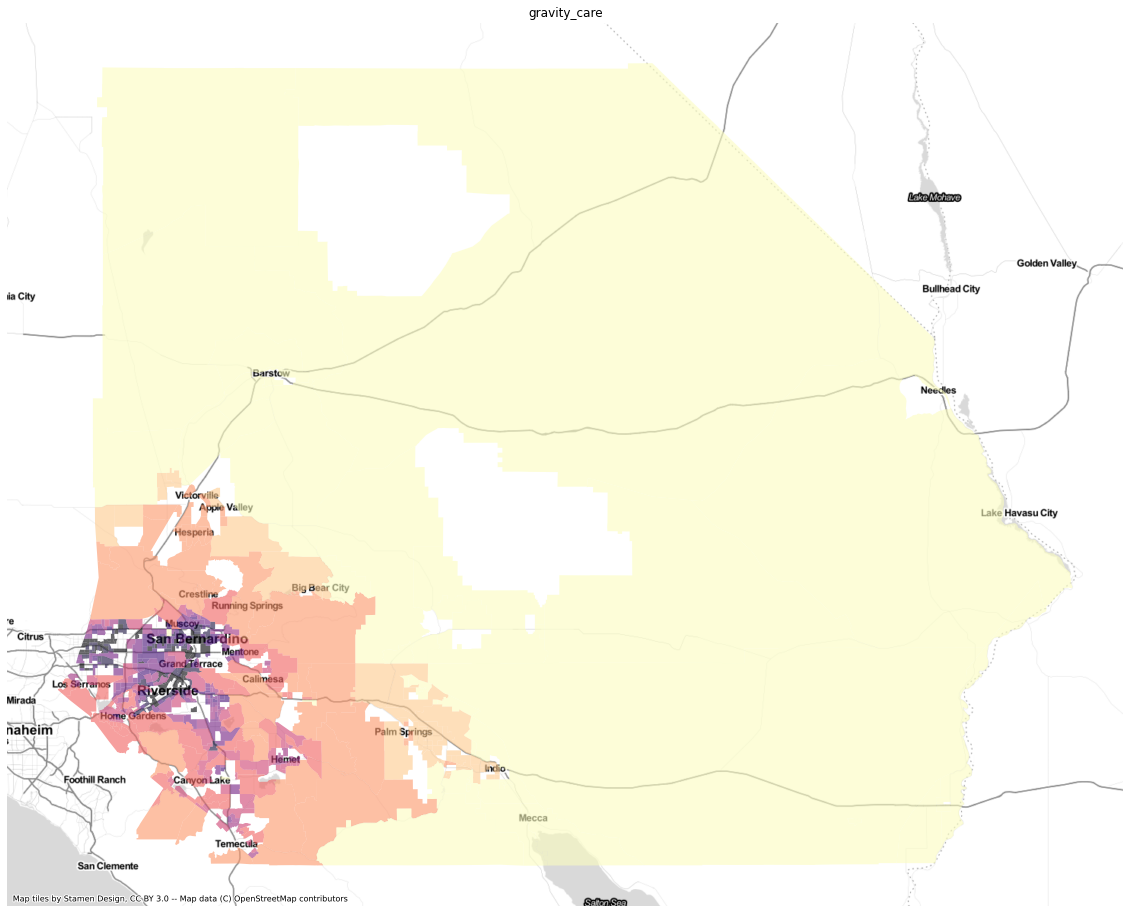

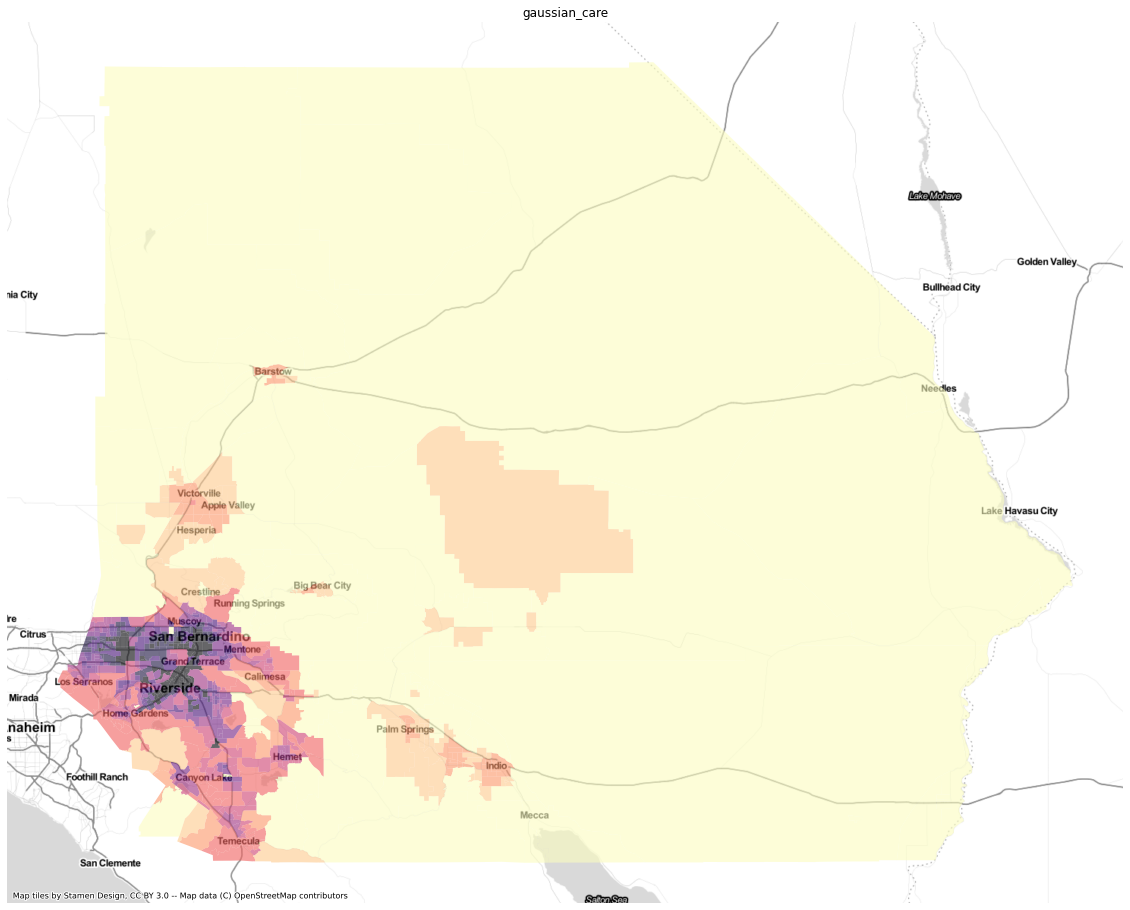

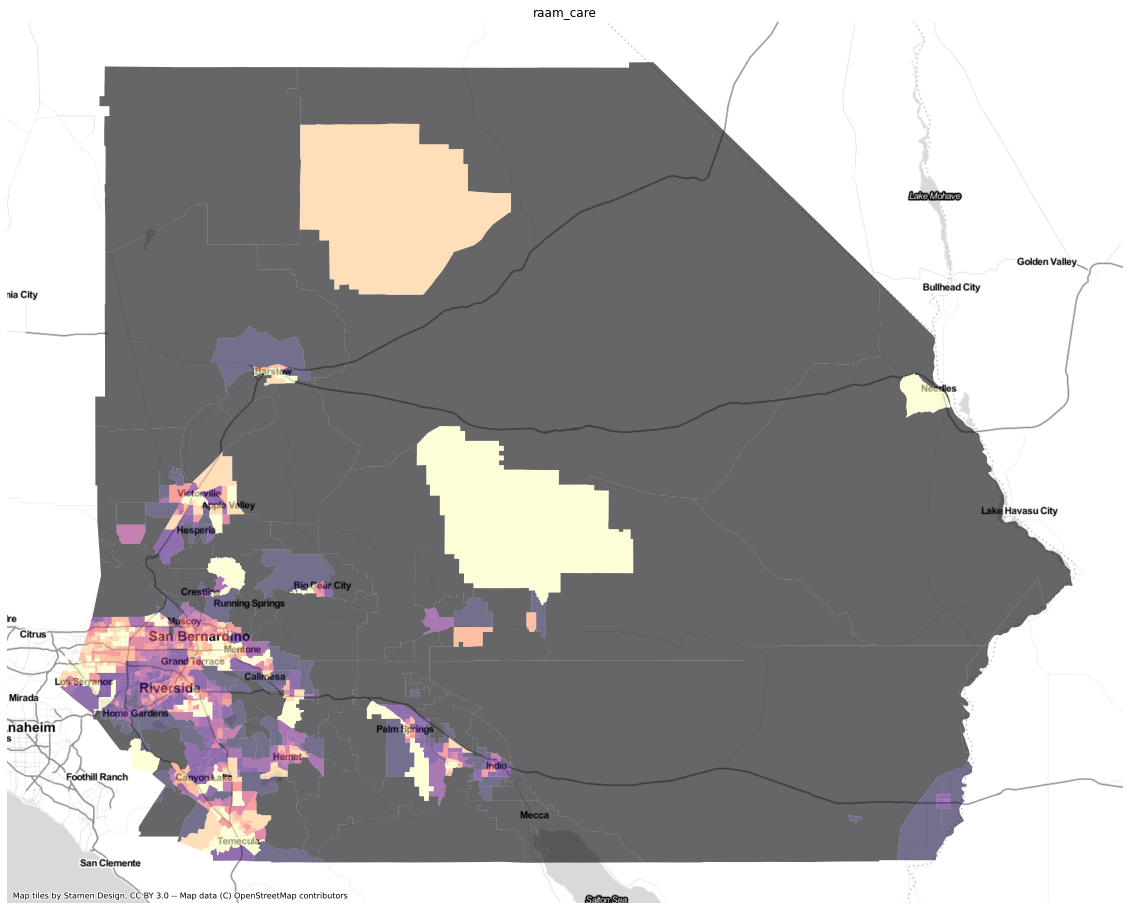

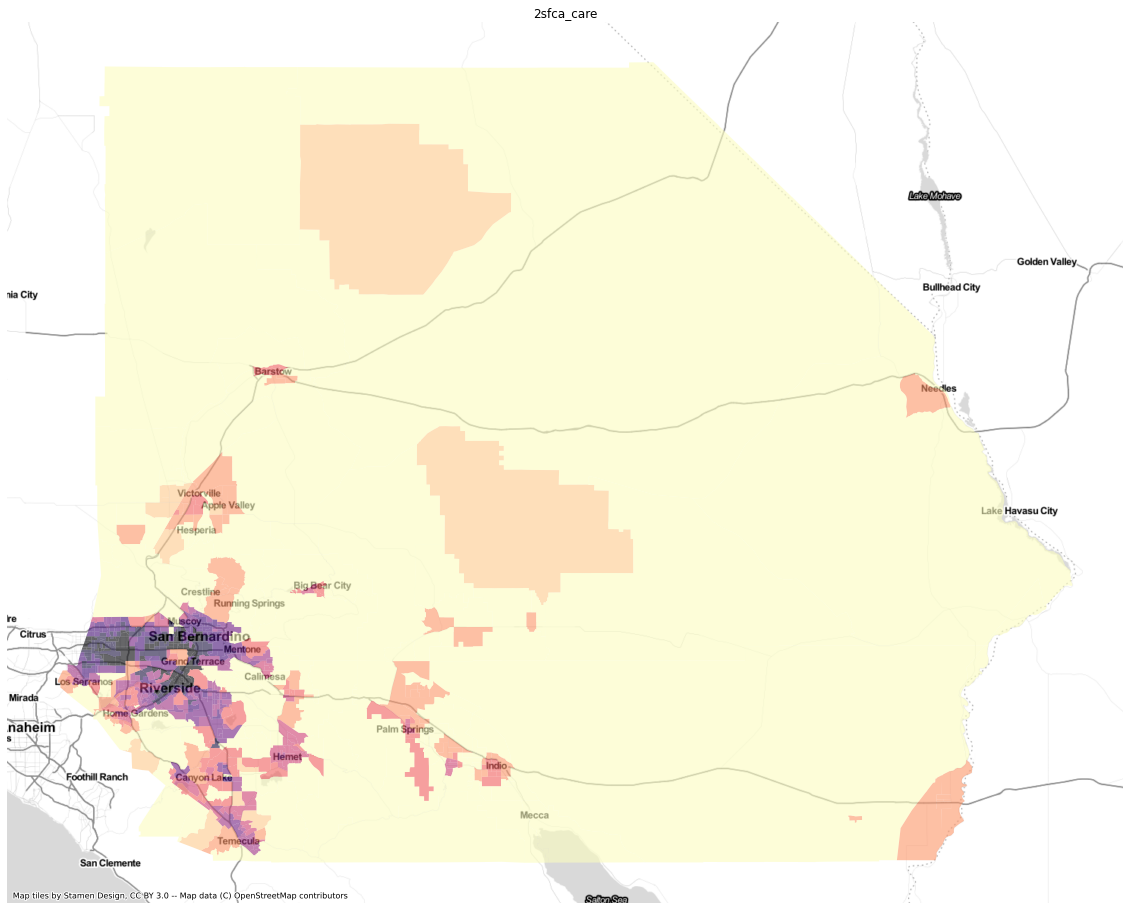

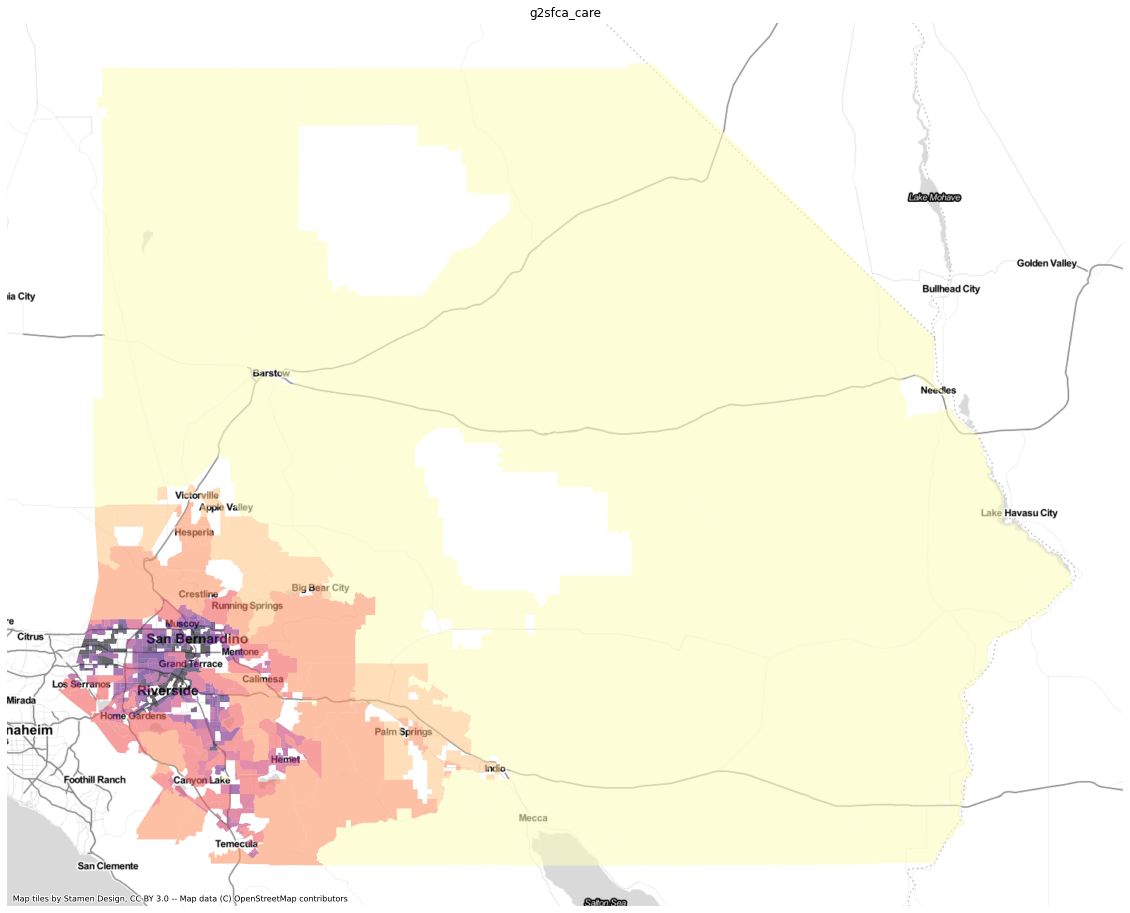

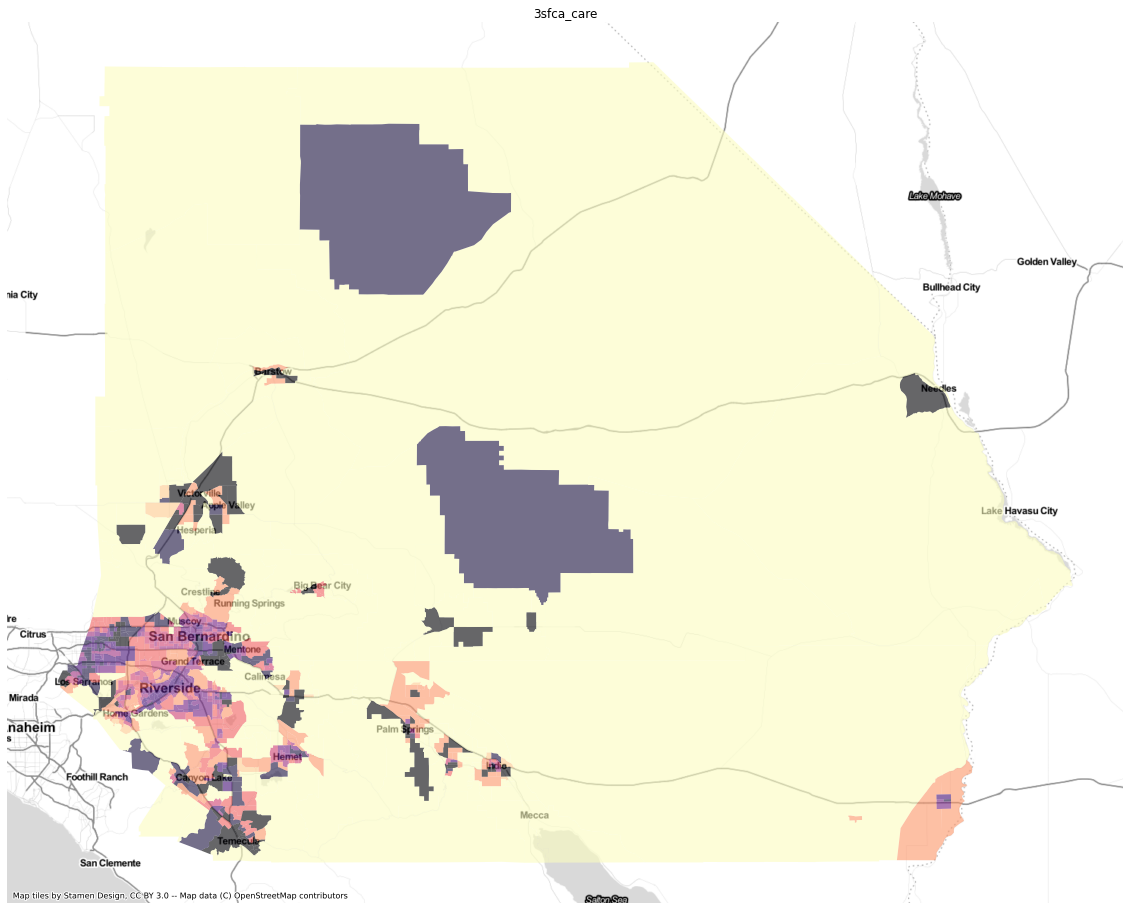

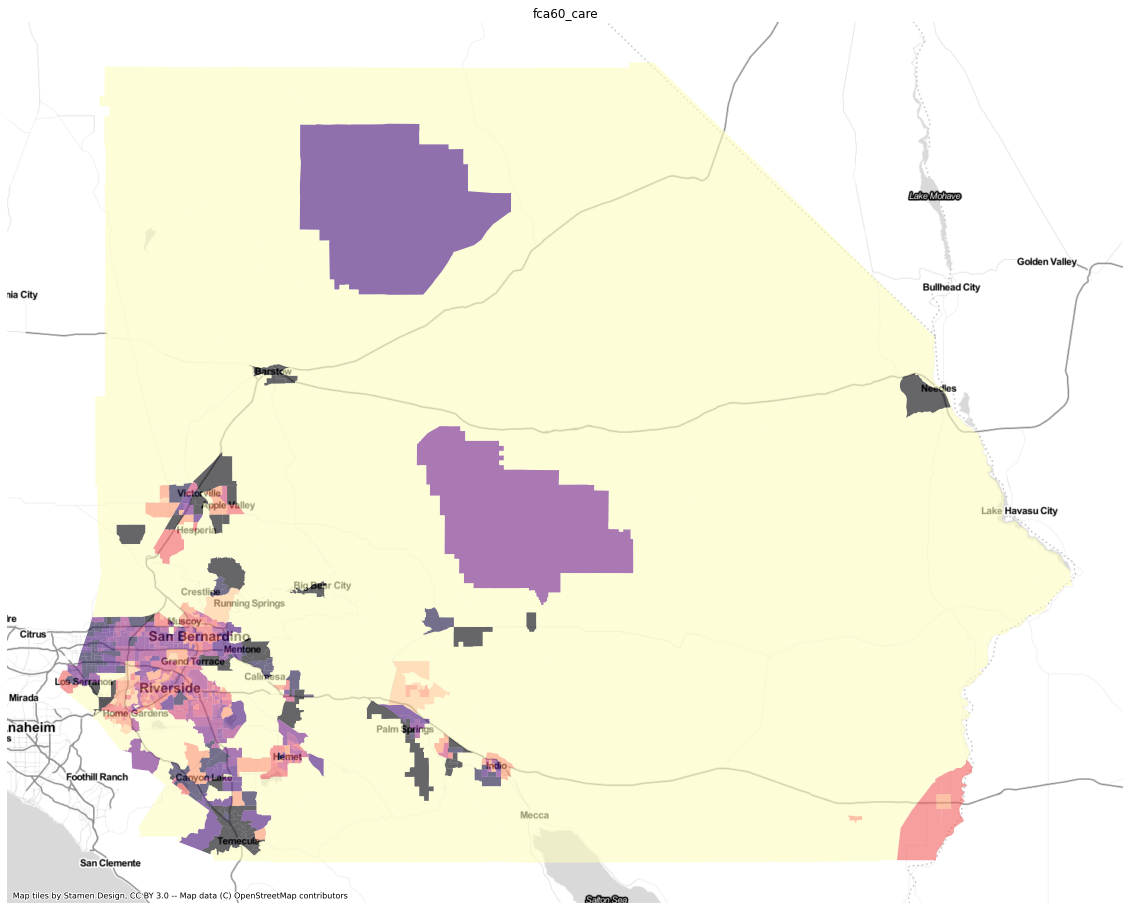

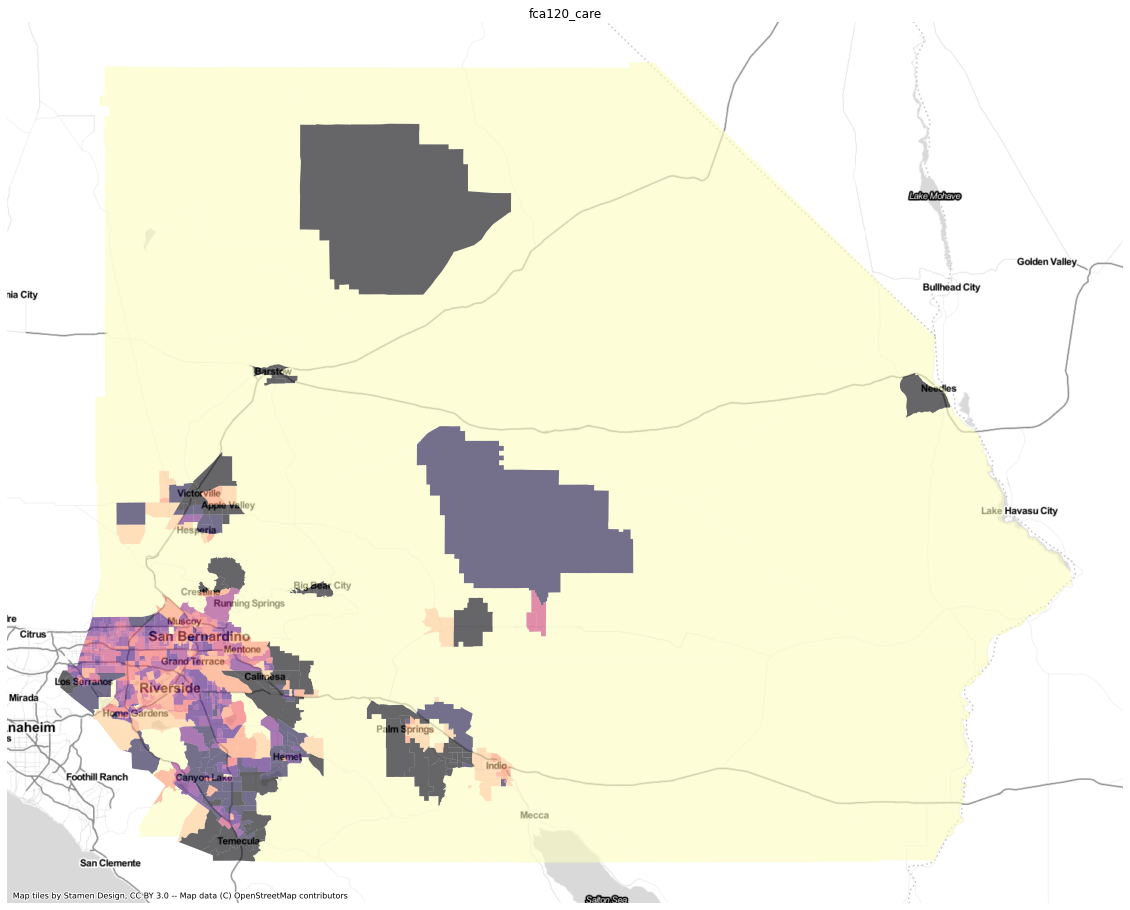

In [44]:
for i in ['gravity_care', 'gaussian_care',
          'raam_care', '2sfca_care', 
         'g2sfca_care', '3sfca_care', 
         'fca60_care', 'fca120_care']:
    fig, ax=plt.subplots( figsize=(20,20))
    results.dropna(subset=[i]).plot(column=i, scheme='quantiles', cmap='magma_r', k=10, ax=ax, alpha=0.6)
    #health.to_crs(3857).plot(ax=ax, color='red')
    ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
    ax.set_title(i)
    ax.axis('off')
    plt.savefig(f'../data/ie_{i}.png')
